In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

In [4]:
num_epochs = 100
learning_rate = 0.01
patience = 8
best_val_loss = 999999

In [5]:

# Loading the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Augmening Data
    transforms.RandomCrop(32, padding=4), # Augmenting Data
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

trainset, valset = torch.utils.data.random_split(dataset, [train_size, val_size])

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 43126843.77it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load pre-trained ResNet18
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

for name, param in model.named_parameters():
    if 'layer1' in name:
        param.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
counter = 0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(testloader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)


    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter == patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break


Epoch 1/100, Training Loss: 2.2299, Training Accuracy: 0.2985, Validation Loss: 2.0967, Validation Accuracy: 0.3417
Epoch 2/100, Training Loss: 1.9930, Training Accuracy: 0.3705, Validation Loss: 1.9757, Validation Accuracy: 0.3869
Epoch 3/100, Training Loss: 1.8914, Training Accuracy: 0.4083, Validation Loss: 1.9255, Validation Accuracy: 0.4331
Epoch 4/100, Training Loss: 1.7385, Training Accuracy: 0.4504, Validation Loss: 1.8275, Validation Accuracy: 0.4355
Epoch 5/100, Training Loss: 1.6466, Training Accuracy: 0.4788, Validation Loss: 1.6249, Validation Accuracy: 0.4794
Epoch 6/100, Training Loss: 1.5800, Training Accuracy: 0.5047, Validation Loss: 1.5326, Validation Accuracy: 0.5221
Epoch 7/100, Training Loss: 1.5079, Training Accuracy: 0.5274, Validation Loss: 1.8016, Validation Accuracy: 0.4674
Epoch 8/100, Training Loss: 1.4600, Training Accuracy: 0.5415, Validation Loss: 1.6046, Validation Accuracy: 0.5240
Epoch 9/100, Training Loss: 1.3988, Training Accuracy: 0.5580, Validatio

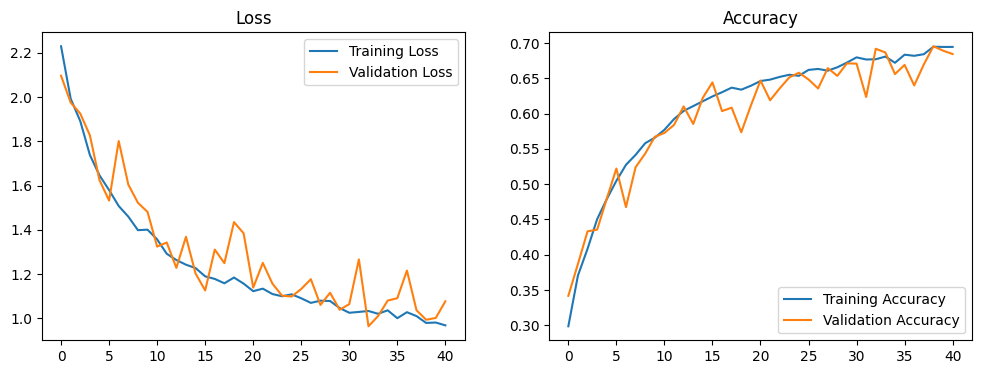

In [11]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()


In [12]:
# Evaluating the model on test data
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().detach().numpy())  # Move to CPU before converting to numpy
            ground_truth.extend(labels.cpu().detach().numpy())    # Move to CPU before converting to numpy
    accuracy = correct / total * 100

    conf_matrix = confusion_matrix(ground_truth, predictions)
    return accuracy, conf_matrix


accuracy, conf_matrix = test(model, testloader)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 68.48%


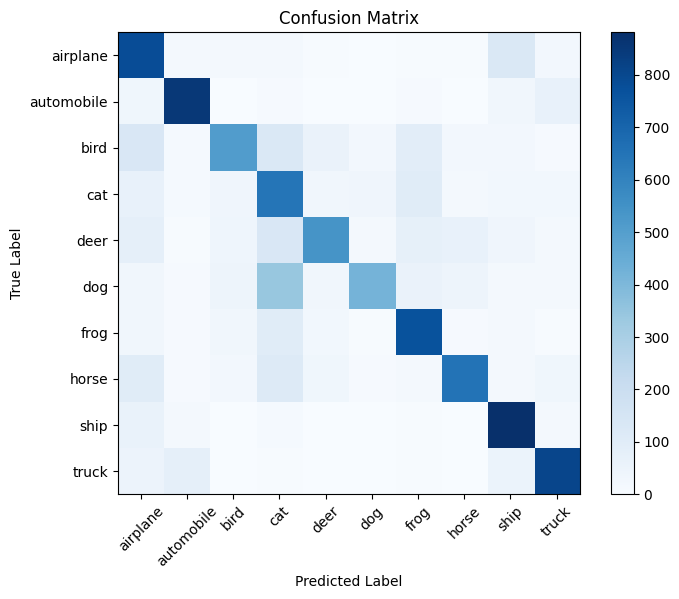

Confusion Matrix:
[[783  19  20  16   6   0   5   4 125  22]
 [ 33 851   2   7   1   0   8   2  30  66]
 [132  11 508 127  56  21  90  24  22   9]
 [ 63  13  36 646  30  37 102  20  27  26]
 [ 77   5  41 131 537  16  74  67  35  17]
 [ 30   7  43 344  28 417  57  42  15  17]
 [ 28  10  28 103  26   6 766   8  20   5]
 [102   7  21 111  32  10  17 651  17  32]
 [ 61  16   3  13   0   1   5   1 881  19]
 [ 51  76   2   5   2   0   4   0  52 808]]


In [13]:
# Display the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
tick_marks = np.arange(10)
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Confusion Matrix:")
print(conf_matrix)
